In [1]:
import os

os.chdir(r'C:\Users\carlo\GitHub\ProjectBuffalo')

In [2]:
import pandas as pd
import numpy as np
import buffalo.algorithm.outliers as ol_algo 

In [3]:
from buffalo.predictor.models import ModelPerformance

## Apple Outlier Detection

In [4]:
model_performance = ModelPerformance.deserialize_from_file(r'cached_data/record.sqlite', testing_id=1)

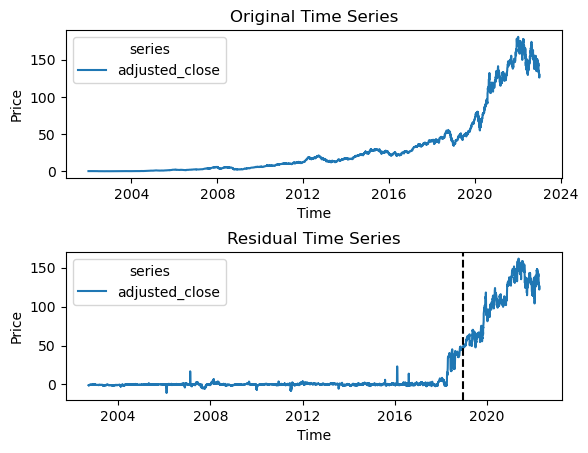

In [5]:
model_performance.plot_residuals()

In [6]:
ol_detection = ol_algo.IterativeTtestOutlierDetection(
    types= pd.DataFrame({'type': ['AO', 'IO', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC', 'TC'], 'delta': [0, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}),
    maxit=4,
    maxit_iloop=4,
    maxit_oloop=4,
    cval=None,
    cval_reduce=0.14286,
    discard_method='bottom-up',
    discard_cval=None,
    tsmethod='ARIMA',
    args_tsmethod={
        "order": (1,1,1),
        "seasonal_order": (0, 0, 0, 0),
        "with_intercept": True
    }
)

In [10]:
original_residuals = pd.concat((model_performance.training_residuals, model_performance.testing_residuals))['adjusted_close']

In [8]:
result_resid, endog_resid, exog_resid = ol_detection.fit(endog=pd.concat((model_performance.training_residuals, model_performance.testing_residuals))['adjusted_close'], exog=None)

C:\Users\carlo\GitHub\ProjectBuffalo\buffalo\algorithm\outliers.py:667: UserWarning: Maximum number of iterations reached for inner loop.
  warnings.warn('Maximum number of iterations reached for inner loop.')
c:\Users\carlo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
c:\Users\carlo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
c:\Users\carlo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
c:\Users\carlo\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used

In [9]:
import matplotlib.pyplot as plt

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(20,10), gridspec_kw={'height_ratios': [1, 1]})
fig.suptitle('Outlier Effect for APPL', size=20)
axs[0].plot(ol_obs, linewidth=1, label = 'Original Series')
axs[0].plot(endog, linewidth=1, label = 'Adjusted Series')
axs[0].scatter(result['t_index'], result['residuals'], c=result.id, cmap='tab10',  marker='o', s=15)
for i, txt in enumerate(result['id']):
    axs[0].annotate(txt, (result['t_index'][i]+15, result['residuals'][i]), fontsize=9)
axs[0].get_xaxis().set_visible(False)
axs[0].legend(loc='upper left', prop={'size': 13})

outlier_effect =  ol_obs - endog
axs[1].plot((outlier_effect), c='r', label = 'Outlier Effect')
axs[1].legend(loc='upper left', prop={'size': 13})
plt.subplots_adjust(wspace=0, hspace=0)